## **Imports**

In [1]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np
import re
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
import matplotlib.pyplot as plt
from torch.nn import MSELoss
import shap

## **Data Preprocessing**

In [2]:
# Load the dataset
dataset = pd.read_csv('battery_feature_extracted.csv')

In [3]:
# Select features and target
X = dataset.drop(columns=['average_voltage'])
y = dataset['average_voltage']

In [4]:
# First split to separate out the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# Second split: separate the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 20% for validation


In [6]:
# Standardizing the features (fit on X_train, apply to all)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)  # Ensure target tensor is of the right shape
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

In [8]:
# Model parameters
num_features = X_train_scaled.shape[1]
output_size = 1  # For regression, we predict a single continuous value

## Transformer Model

In [9]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.residual = nn.Linear(input_size, output_size)  # Residual connection
        self.alpha = nn.Parameter(torch.tensor(0.5))  # Learnable weight for residual

    def forward(self, x):
        residual = self.residual(x)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return self.alpha * x + (1 - self.alpha) * residual  # Weighted combination

In [10]:
# Define the TabTransformer model with FFNN
class TabTransformer(nn.Module):
    def __init__(self, num_features, output_size=1, dim_embedding=64, num_heads=4, num_layers=4, ffnn_hidden_size=128):
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True, dropout=0.70)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Replace the regression layer with a custom feed-forward neural network
        self.ffnn = FeedForwardNN(dim_embedding, ffnn_hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Adding a sequence dimension
        x = self.transformer(x)
        x = x[:, 0, :]  # Select the first token (or the entire sequence can be aggregated differently)
        x = self.ffnn(x)  # Pass through the feed-forward network
        return x

In [11]:
# Initialize the model, loss, and optimizer
model = TabTransformer(
    num_features=num_features,  # Input feature size
    output_size=output_size,   # Output size (1 for regression)
    dim_embedding=128,         # Embedding dimension
    num_heads=2,               # Number of attention heads
    num_layers=2,              # Number of transformer layers
    ffnn_hidden_size=128       # Hidden size for the feed-forward neural network
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

class CompositeLoss(nn.Module):
    def __init__(self):
        super(CompositeLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()
    
    def forward(self, outputs, targets):
        mse = self.mse_loss(outputs, targets)
        mae = self.mae_loss(outputs, targets)
        return mse + 0.5 * mae  # Adjust weight as needed

# Loss function: Composite Loss
criterion = CompositeLoss()

# Optimizer: Adam with a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.00075)

In [12]:
# Initialize lists to store losses and accuracy for plotting
training_losses = []
validation_losses = []

In [13]:
# Training loop with validation
for epoch in range(2000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    train_loss = criterion(output, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)

    # Store the losses for plotting
    training_losses.append(train_loss.item())
    validation_losses.append(val_loss.item())

    # Print training and validation loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')



Epoch 0, Training Loss: 14.618587493896484, Validation Loss: 3.8940839767456055
Epoch 10, Training Loss: 4.324463367462158, Validation Loss: 7.609868049621582
Epoch 20, Training Loss: 4.306753158569336, Validation Loss: 6.6373515129089355
Epoch 30, Training Loss: 4.2974677085876465, Validation Loss: 6.104981422424316
Epoch 40, Training Loss: 4.238439559936523, Validation Loss: 6.7190423011779785
Epoch 50, Training Loss: 4.064064979553223, Validation Loss: 5.313593864440918
Epoch 60, Training Loss: 3.6358814239501953, Validation Loss: 4.783493995666504
Epoch 70, Training Loss: 3.2283945083618164, Validation Loss: 4.291328430175781
Epoch 80, Training Loss: 2.9308583736419678, Validation Loss: 4.041813373565674
Epoch 90, Training Loss: 2.670541763305664, Validation Loss: 4.066948890686035
Epoch 100, Training Loss: 2.439173698425293, Validation Loss: 3.6372742652893066
Epoch 110, Training Loss: 2.3264517784118652, Validation Loss: 3.1990747451782227
Epoch 120, Training Loss: 2.174887657165

**SHAP**

In [16]:
# Set device and move model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.device = device  # Attach for SHAP compatibility

In [17]:
# Move data to CPU and convert to numpy
X_train_np = X_train_tensor.cpu().detach().numpy()
X_test_np = X_test_tensor.cpu().detach().numpy()

In [18]:
# Sample background and test data
background = X_train_np[np.random.choice(X_train_np.shape[0], 100, replace=False)]
X_sample = X_test_np[:200]

In [19]:
# Define a wrapper for the PyTorch model that outputs numpy
def wrapped_model(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(model.device)
    with torch.no_grad():
        preds = model(x_tensor).cpu().numpy()
    return preds


In [20]:
# Create SHAP explainer
#explainer = shap.Explainer(wrapped_model, background)
#explainer = shap.Explainer(wrapped_model, background, algorithm="permutation")
explainer = shap.KernelExplainer(wrapped_model, background)

In [21]:
# Compute SHAP values
shap_values = explainer(X_sample)

  0%|          | 0/200 [00:00<?, ?it/s]

In [22]:
# Set feature names if available
shap_values.feature_names = X.columns.tolist()  # If X is a DataFrame with column names


Top 20 Features:
energy_grav: 1.084198
capacity_grav: 0.841393
formula_discharge_O: 0.132886
formula_charge_O: 0.123371
formula_discharge_Li: 0.062191
working_ion_Li: 0.056406
formula_discharge_P: 0.025130
working_ion_Zn: 0.023484
site18_magmom: 0.018819
formula_discharge_V: 0.017544
site36_c: 0.016705
site37_y: 0.016446
site38_c: 0.015720
formula_discharge_Zn: 0.015652
formula_discharge_Na: 0.015352
formula_charge_P: 0.015218
site75_z: 0.014393
working_ion_Na: 0.012709
formula_charge_Mn: 0.012630
formula_charge_F: 0.012373


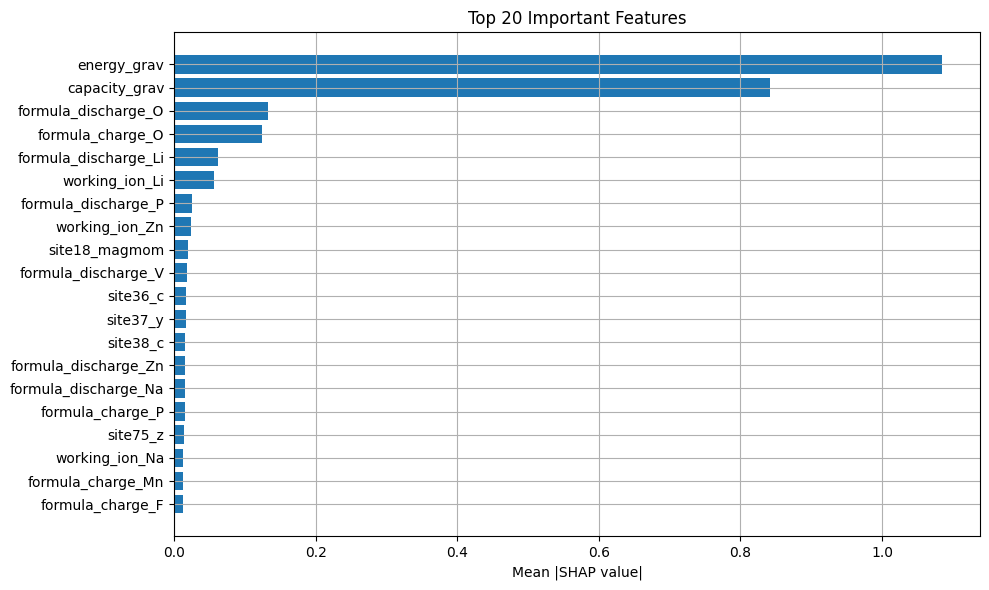

In [36]:
# 1. Extract SHAP values properly
shap_array = shap_values.values  # shape: (200, 3226, 1)

# Flatten the last dimension
shap_array = shap_array.squeeze(-1)  # now shape = (200, 3226)

# 2. Mean absolute SHAP per feature
mean_abs_shap = np.abs(shap_array).mean(axis=0)  # shape = (3226,)

# 3. Get top 20 features
top_indices = np.argsort(mean_abs_shap)[-20:][::-1]
top_features = [shap_values.feature_names[i] for i in top_indices]
top_shap_values = mean_abs_shap[top_indices]

# 4. Print top features and values
print("\nTop 20 Features:")
for name, val in zip(top_features, top_shap_values):
    print(f"{name}: {val:.6f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_shap_values)
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(True)
plt.show()